In [8]:
import _background as bg
import pandas as pd
import numpy as np

from molNet.featurizer.featurizer import FeaturizerList
from molNet.featurizer.atom_featurizer import atom_symbol_one_hot_from_set, atom_formal_charge, atom_partial_charge, atom_hybridization_one_hot, atom_is_in_ring_size_3_to_20_one_hot, atom_is_aromatic, atom_is_in_ring
from molNet.dataloader.molecule_loader import PytorchGeomMolDfLoader

import pytorch_lightning as pl
import torch
import molNet

In [9]:
dataset=pd.read_csv("data/patents_ochem_enamine_bradley_begstrom_training_edit.csv")
dataset["rd_mol"]=dataset["smiles"].apply(bg.pd_MolFromSmiles)
dataset["mpK"]= dataset["mpC"]+273
dataset["logmpK"]=np.log(dataset["mpK"])
c_mp_atom_symbol_featurizer = atom_symbol_one_hot_from_set(dataset["rd_mol"],only_mass=True)


featurizer = FeaturizerList([
    c_mp_atom_symbol_featurizer,
    atom_formal_charge,
    atom_partial_charge,
    atom_hybridization_one_hot,
    atom_is_in_ring,
    atom_is_aromatic,
])

In [10]:
loader_MPModel1 = PytorchGeomMolDfLoader(dataset,mol_create_source='smiles',#"all",
                                    atom_featurizer=featurizer,
                                         columns=[],
                                         y_columns=["mpK"],
#                                     y_properties=["mpK"],
                                     seed=1,
#                                     to_graph_params={
 #                                        "atom_featurizer":featurizer,
  #                                       "with_mol_graph":True
   #                                  },
                                    batch_size=128,#num_workers=4
                                    #follow_batch=["y"]
                                             #     num_workers=28
                                        # to_graph_input_kwargs=dict(keep_string_data=True,include_graph_features_titles=True)
                                         
                                    )
#loader_MPModel1.setup()

In [11]:
#for batch in loader_MPModel1.train_dataloader():
#    print(batch)
#    break
#dir(molNet)

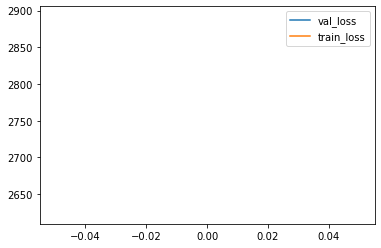

Epoch 0, global step 1504: val_loss reached 2622.94604 (best 2622.94604), saving model to "models/MPModel1/logs/tensorboard/default/version_71/checkpoints/epoch=0-step=1504.ckpt" as top 1
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: you defined a test_step but have no test_dataloader. Skipping test loop
  warnings.warn(*args, **kwargs)


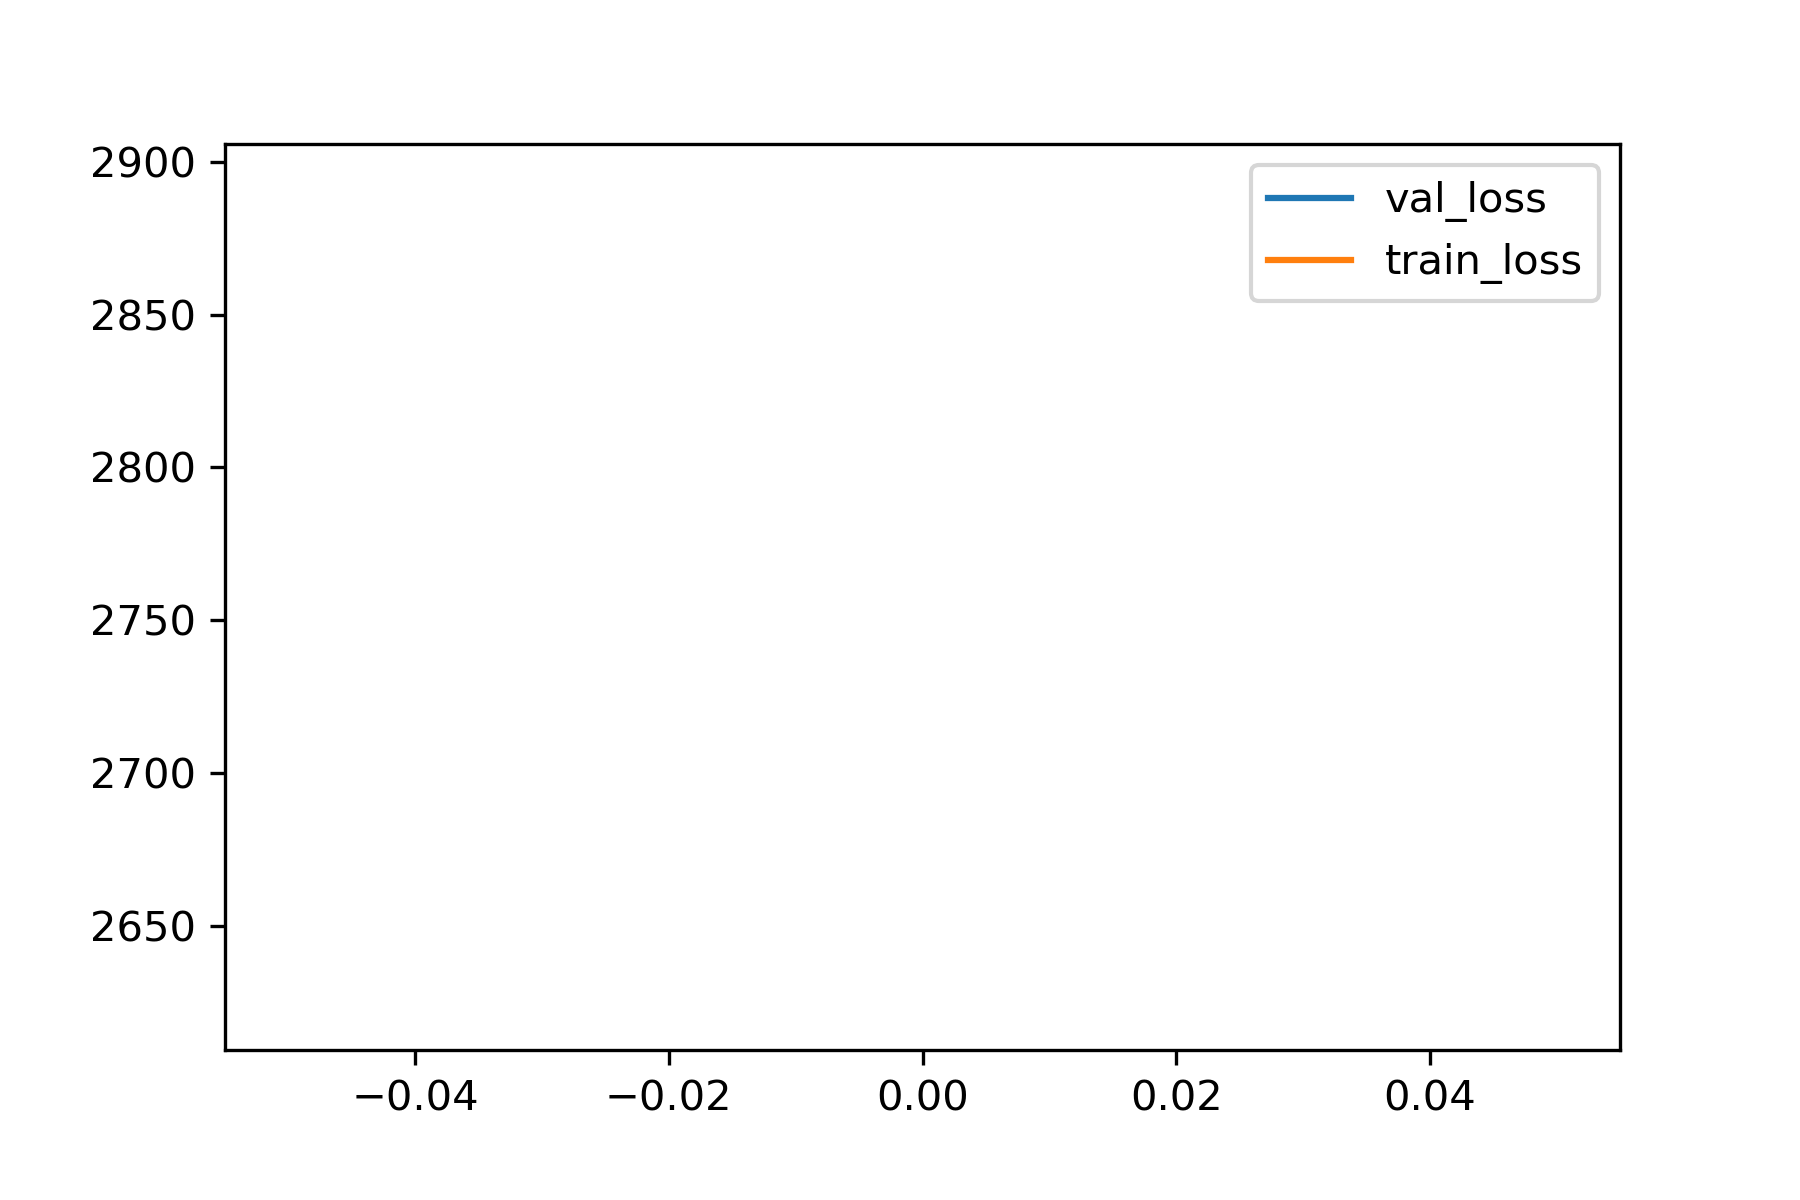

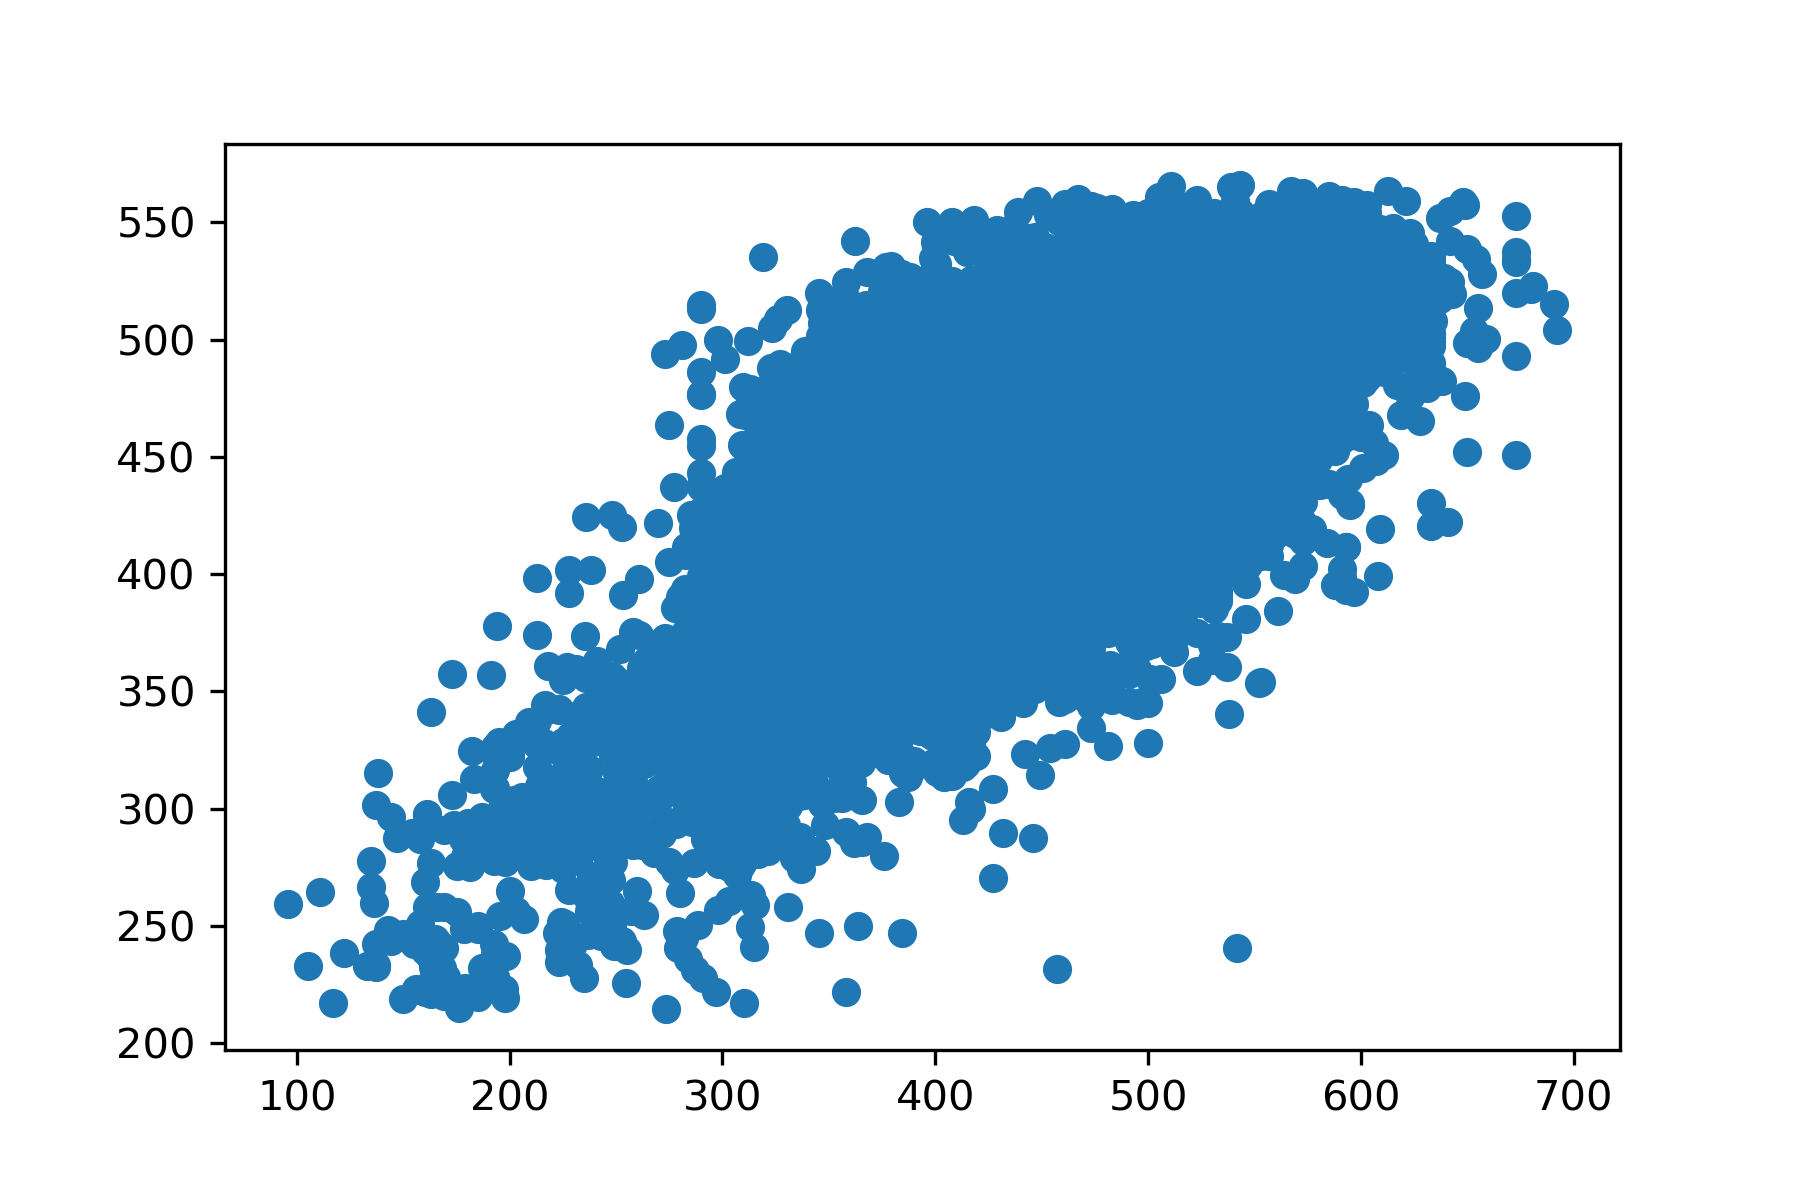

In [13]:
class MPModel1(pl.LightningModule):
    def __init__(self,in_size,name="none",n_chem_layer=6,chem_layer_feats_out=40,chem_layer_gc_out=30,chem_layer_net_sizes=10,chem_layer_net_count=2,
                 collector_net_depth=3,collector_net_depth_red_fac=2,lr=1e-3,poolings=["pool_wsum"]):
        super().__init__()
        self.save_hyperparameters()
        
        #print(self.hparams)
        
        chem_layer=[
            bg.ChemGCLayer(in_size,[chem_layer_net_sizes if chem_layer_net_sizes >=0 else in_size]*chem_layer_net_count,chem_layer_gc_out,chem_layer_feats_out,bias=False,linear_activation=torch.nn.ELU(),concat_input=True)
        ]
        for n in range(n_chem_layer-1):
            chem_layer.append(bg.ChemGCLayer(chem_layer[-1].feats_out,[chem_layer_net_sizes if chem_layer_net_sizes >=0 else chem_layer[-1].feats_out]*chem_layer_net_count,chem_layer_gc_out,chem_layer_feats_out,bias=False,linear_activation=torch.nn.ELU(),concat_input=True))

        self.chem_layer=torch.nn.Sequential(*chem_layer)
        
        
        self.lr = lr
        
        poolings_layer=[]
        for p in poolings:
            if p=="pool_max":
                poolings_layer.append(molNet.nn.models.graph_convolution.PoolMax())
            elif p=="pool_min":
                poolings_layer.append(molNet.nn.models.graph_convolution.PoolMin())
            elif p=="pool_mean":
                poolings_layer.append(molNet.nn.models.graph_convolution.PoolMean())
            elif p=="pool_sum":
                poolings_layer.append(molNet.nn.models.graph_convolution.PoolSum())
            elif p=="pool_wsum":
                poolings_layer.append(molNet.nn.models.graph_convolution.PoolWeightedSum(self.chem_layer[-1].feats_out,normalize=False))
            elif p=="pool_nwsum":
                poolings_layer.append(molNet.nn.models.graph_convolution.PoolWeightedSum(self.chem_layer[-1].feats_out,normalize=True))

            else:
                raise Exception("unknown pooling '{}'".format(p))
        
        self.pooling=molNet.nn.models.graph_convolution.MergedPooling(
            {"pool_{}".format(i):poolings_layer[i] for i in range(len(poolings_layer))}
        )
        
        self.post_pool_norm=torch.nn.Sigmoid()
        
        collector_net = [
            torch.nn.Linear(len(self.pooling)*self.chem_layer[-1].feats_out,max(1,int(len(self.pooling)*self.chem_layer[-1].feats_out/collector_net_depth_red_fac))),
            torch.nn.ReLU()
        ]
        
        for i in range(collector_net_depth-1):
            collector_net.append(torch.nn.Linear(collector_net[-2].out_features,max(1,int(collector_net[-2].out_features/collector_net_depth_red_fac))))
            collector_net.append(torch.nn.ReLU())
        collector_net.append(torch.nn.Linear(collector_net[-2].out_features,1))
        self.nn=torch.nn.Sequential(*collector_net)
        
        
        
        self.lossf=torch.nn.MSELoss()#torch.nn.BCEWithLogitsLoss()#

    def unpacked_forward(self, feats, edges, batch,graph_features):
        feats,_,_ = self.chem_layer((feats, edges, batch))

        y_hat = self.pooling(feats,batch)
        y_hat = self.post_pool_norm(y_hat)
        y_hat = self.nn(y_hat)
        return y_hat
      
    def forward(self,batch):
        return self.unpacked_forward(feats=batch.x,edges=batch.edge_index,batch=batch.batch,graph_features=batch.x_graph_features)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer
    
    def batch_to_loss(self,batch):
        y_hat=self(batch)
        loss =  self.lossf(y_hat, batch.y_graph_features)
        return loss
    
    def training_step(self,batch, *args, **kwargs):
        #print(y_hat.shape, batch.y.shape)
        loss=self.batch_to_loss(batch)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self,batch, *args, **kwargs):
        loss=self.batch_to_loss(batch)
        self.log('val_loss', loss)
        return loss
    
    def test_step(self,batch, *args, **kwargs):
        loss=self.batch_to_loss(batch)
        self.log('test_loss', loss)
        return loss

model_MPModel1 = MPModel1(in_size=len(featurizer))
try:
    data_MPModel1
except:
    model_MPModel1,data_MPModel1 = bg.default_model_run(
            "MPModel1",
            model_MPModel1,
            loader_MPModel1,
                        force_run=bg.REMODEL,
                        early_stopping=True,
                        max_epochs=1,
                        early_stopping_delta=10,
                        detect_lr=False,

        )

In [10]:
import optuna
from pytorch_lightning.utilities import rank_zero_only
from pytorch_lightning.loggers import LightningLoggerBase
from pytorch_lightning.loggers.base import rank_zero_experiment
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

class DictLogger(LightningLoggerBase):
    
    def __init__(self,n):
        super().__init__(n)
        self.metrics=[]
        
    @property
    def name(self):
        return 'MyLogger'

    @property
    @rank_zero_experiment
    def experiment(self):
        # Return the experiment object associated with this logger.
        pass

    @property
    def version(self):
        # Return the experiment version, int or str.
        return '0.1'

    @rank_zero_only
    def log_hyperparams(self, params):
        # params is an argparse.Namespace
        # your code to record hyperparameters goes here
        pass

    @rank_zero_only
    def log_metrics(self, metrics, step):
        # metrics is a dictionary of metric names and values
        # your code to record metrics goes here
        #if step%500==0:
        print(step,metrics,end="\r")
        self.metrics.append(metrics)

    @rank_zero_only
    def save(self):
        # Optional. Any code necessary to save logger data goes here
        # If you implement this, remember to call `super().save()`
        # at the start of the method (important for aggregation of metrics)
        super().save()

    @rank_zero_only
    def finalize(self, status):
        # Optional. Any code that needs to be run after training
        # finishes goes here
        pass

study = optuna.create_study(study_name="tune_study",
                            direction="minimize",
                            storage="sqlite:///"+os.path.join(data_MPModel1["files"]["model_dir"],"optuna.db"),
                           load_if_exists=True
                           )

def objective(trial):
    
    poolings=[]
    for w in ["use_pool_min","use_pool_max","use_pool_mean","use_pool_sum","use_pool_wsum","use_pool_nwsum"]:
        if trial.suggest_categorical(w,[True,False,False]):
            poolings.append(w.replace("use_",""))
    
    if len(poolings)==0:
        poolings=["pool_min"]
        #return np.nan
    
    _model = MPModel1(in_size=len(featurizer),
                              n_chem_layer = trial.suggest_int("n_chem_layer",2,3),
                              chem_layer_feats_out=25,#trial.suggest_int("chem_layer_feats_out",10,30),
                              chem_layer_gc_out=13,#trial.suggest_int("chem_layer_gc_out",10,20),
                              chem_layer_net_sizes=trial.suggest_int("chem_layer_net_sizes",4,10),
                              chem_layer_net_count=1,#trial.suggest_int("chem_layer_net_count",1,3),
                              collector_net_depth=trial.suggest_int("collector_net_depth",2,5),
                              collector_net_depth_red_fac=trial.suggest_float("collector_net_depth_red_fac",1,2.5),
                              poolings=poolings,
                              
                      lr=trial.suggest_loguniform("lr",1e-3, 1e-2),
                             )
    display(trial.params)
    #display(_model)
    logger=DictLogger(trial.number)
    trainer = pl.Trainer(
        logger=logger,
        max_epochs=50,
        progress_bar_refresh_rate=0,
        gpus=torch.cuda.device_count(),
        callbacks=[EarlyStopping(
                        monitor='val_loss',patience=10,
                min_delta=10,
            )]
        )
    
    trainer.fit(_model,loader_MPModel1)
    
    
    return logger.metrics[-1]["val_loss"]

#for i in range(20):
#optuna.study.delete_study(study_name="tune_study",
#                            storage="sqlite:///"+os.path.join(data_MPModel1["files"]["model_dir"],"optuna.db"),
#                           )

study.optimize(objective, n_trials=5000)

print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


[I 2021-03-23 11:05:59,944] Using an existing study with name 'tune_study' instead of creating a new one.


{'use_pool_min': True,
 'use_pool_max': False,
 'use_pool_mean': False,
 'use_pool_sum': True,
 'use_pool_wsum': True,
 'use_pool_nwsum': False,
 'n_chem_layer': 2,
 'chem_layer_net_sizes': 8,
 'collector_net_depth': 3,
 'collector_net_depth_red_fac': 1.2520322918369953,
 'lr': 0.00628149715749498}

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name           | Type          | Params
-------------------------------------------------
0 | chem_layer     | Sequential    | 1.7 K 
1 | pooling        | MergedPooling | 26    
2 | post_pool_norm | Sigmoid       | 0     
3 | nn             | Sequential    | 9.1 K 
4 | lossf          | MSELoss       | 0     
-------------------------------------------------
10.8 K    Trainable params
0         Non-trainable params
10.8 K    Total params
0.043     Total estimated model params size (MB)
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 28 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
[W 2021-03-23 11:06:02,353

AttributeError: 'Batch' object has no attribute 'graph_features'

/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/ipykernel_launcher.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  """Entry point for launching an IPython kernel.


<AxesSubplot:title={'center':'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

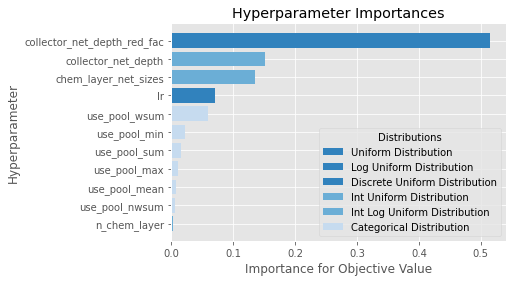

In [38]:
optuna.visualization.matplotlib.plot_param_importances(study)

In [12]:
study.trials_dataframe().sort_values("value").head(20)
    

NameError: name 'study' is not defined

In [42]:
trial = study.best_trial
print("Best trial ({}):".format(trial.number))
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Best trial (842):
  Value: 2025.46044921875
  Params: 
    chem_layer_net_sizes: 8
    collector_net_depth: 3
    collector_net_depth_red_fac: 1.2553630695420823
    lr: 0.006772567657086149
    n_chem_layer: 2
    use_pool_max: True
    use_pool_mean: True
    use_pool_min: True
    use_pool_nwsum: True
    use_pool_sum: False
    use_pool_wsum: False


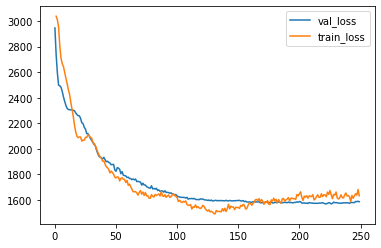

Epoch 249, step 376249: val_loss was not in top 1
/home/julian/anaconda3/envs/molNet/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: you defined a test_step but have no test_dataloader. Skipping test loop
  warnings.warn(*args, **kwargs)


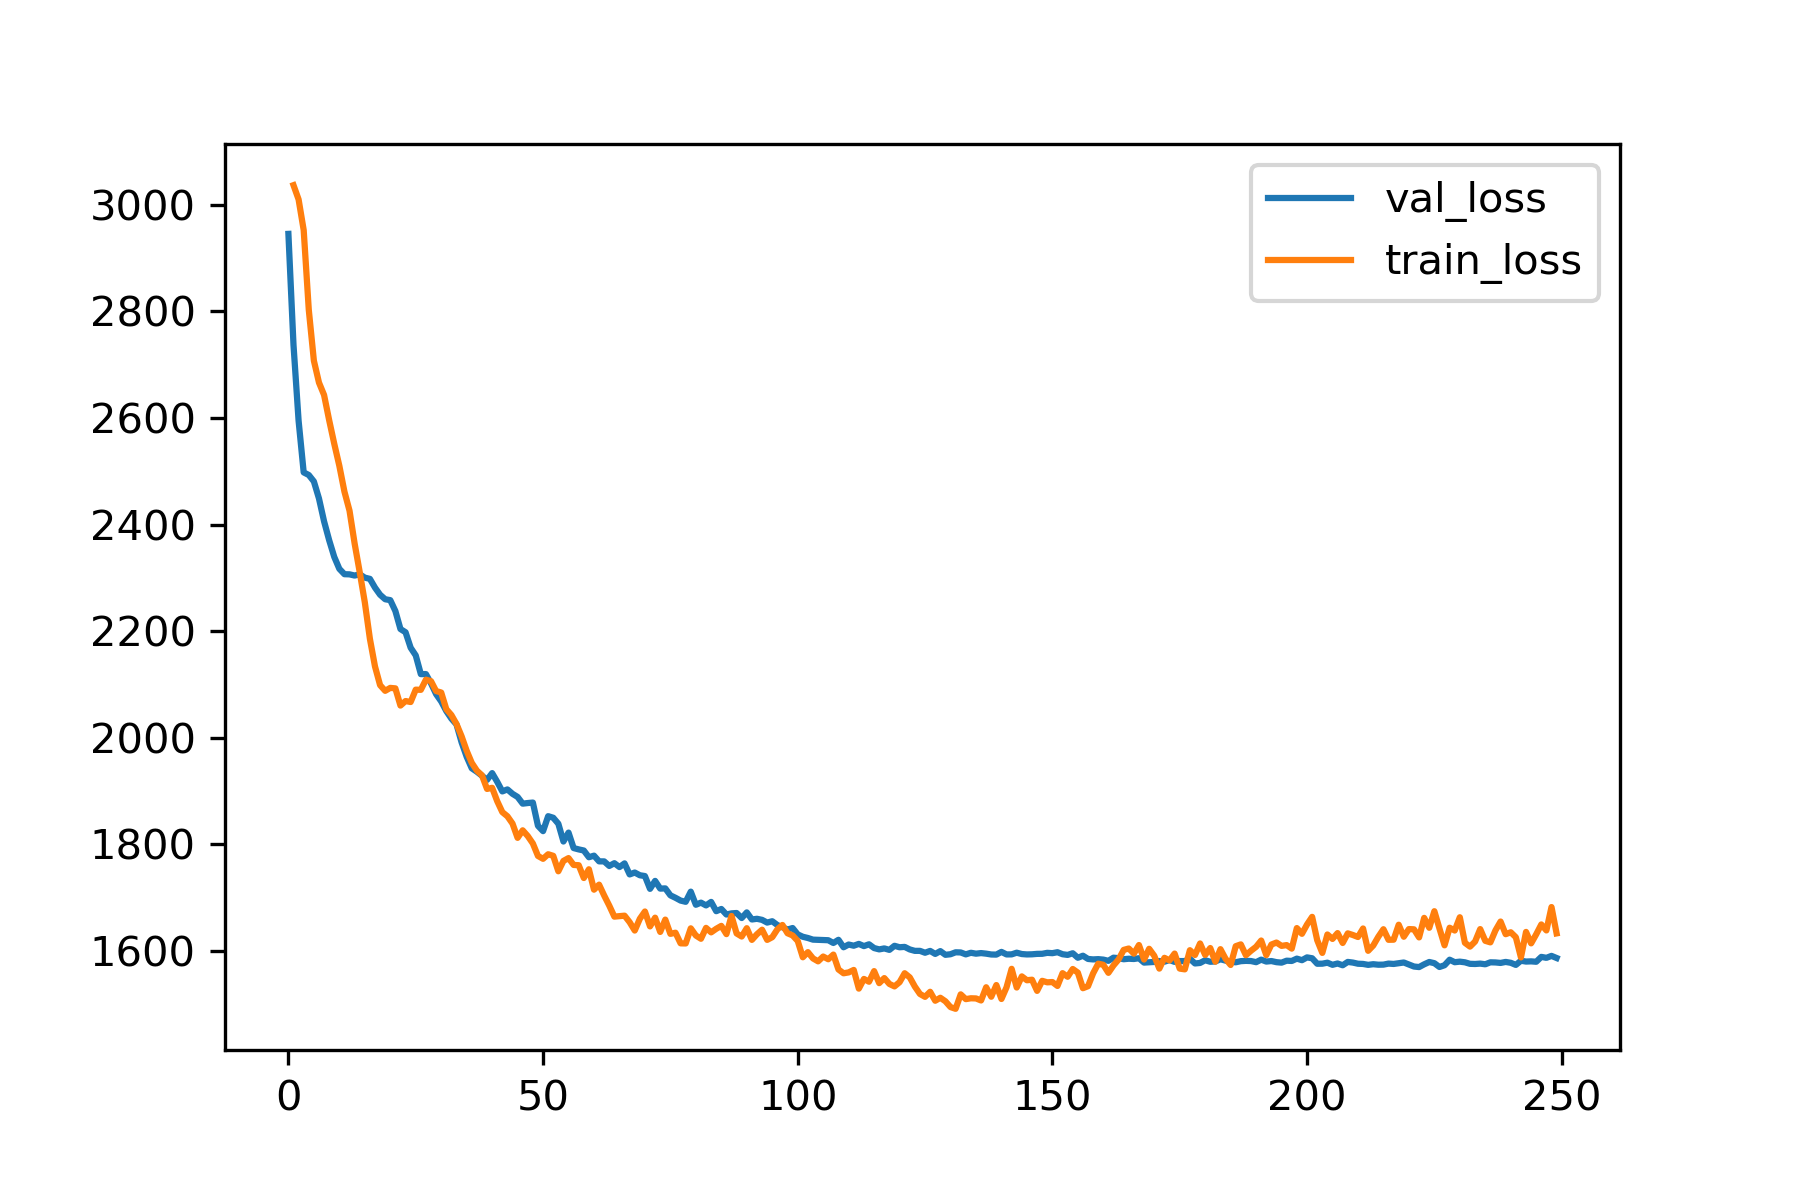

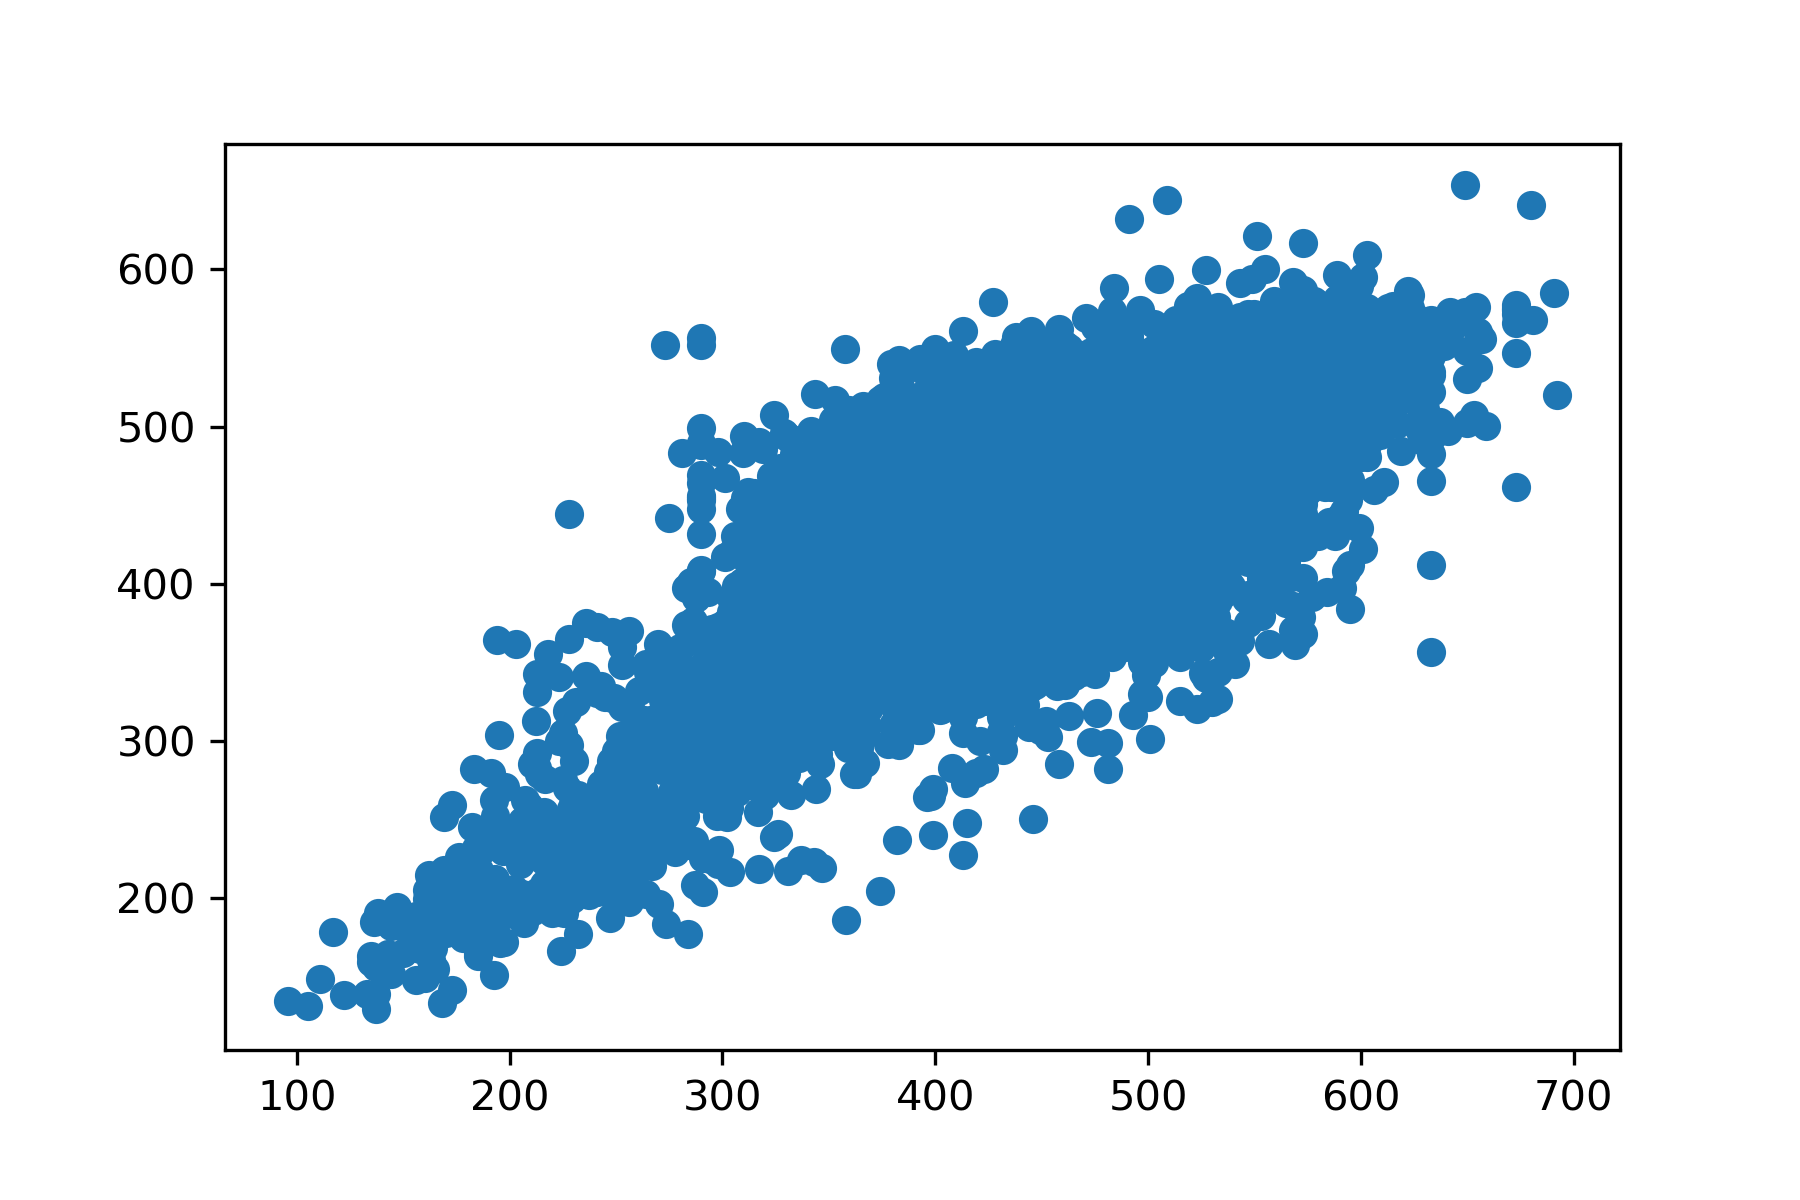

In [18]:
model_MPModel1 = MPModel1(in_size=len(featurizer),
                              n_chem_layer = 2,
                              chem_layer_feats_out=25,
                              chem_layer_gc_out=13,
                              chem_layer_net_sizes=-1,#8,
                              chem_layer_net_count=1,
                              collector_net_depth=3,
                              collector_net_depth_red_fac=1.2553630695420823,
                              poolings=["pool_min","pool_max","pool_mean","pool_nwsum"],
                              lr=0.001,
                             )

model_MPModel1,data_MPModel1 = bg.default_model_run(
        "MPModel1",
        model_MPModel1,
        loader_MPModel1,
                      force_run=True,#bg.REMODEL,
                      #force_test_data_reload=True,
                    #min_epochs=200,
                    early_stopping=True,
                    max_epochs=250,
                    early_stopping_delta=10,
                   detect_lr=False,
                    early_stop_patience=50,

    )

In [19]:
#list(model_MPModel1.parameters())
model_parameters = filter(lambda p: p.requires_grad, model_MPModel1.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

149325

In [20]:
true=[]
pred=[]
try:
    loader_MPModel1.train_dataloader()
except:
    loader_MPModel1.setup()
    
for l in [
        loader_MPModel1.train_dataloader(),
          loader_MPModel1.val_dataloader(),
          loader_MPModel1.test_dataloader()
         ]:
    for d in l:
        pred.extend(model_MPModel1(d).detach().flatten().numpy().tolist())
        true.extend(d.y_graph_features.flatten().numpy().tolist())
        
    #print(()-np.exp(d.y.numpy())).mean())

pred=np.array(pred)
true=np.array(true)

In [23]:
dmin=min(true.min(),pred.min())
dmax=max(true.max(),pred.max())
dmin,dmax = dmin-(dmax-dmin)*0.05,dmax+(dmax-dmin)*0.05

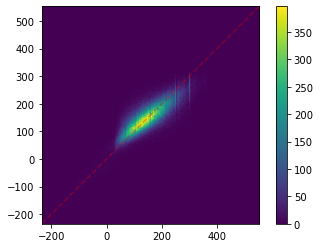

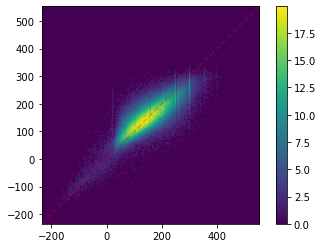

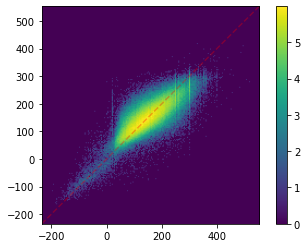

In [89]:
n=200
heatmap=np.zeros((n,n))
lin=np.linspace(dmin,dmax,n)
for i in range(len(pred)):
    y=np.argmin(np.abs(lin-true[i]))
    x=np.argmin(np.abs(lin-pred[i]))
    heatmap[x,y]+=1#/np.abs(true[i]-273)
    #print(x,y,true[i],pred[i],lin.min(),lin.max())
    #break
heatmap=heatmap[::-1,:]

bg.plt.plot(np.arange(lin.min()-273,lin.max()-273),np.arange(lin.min()-273,lin.max()-273),"r--",alpha=0.3)
bg.plt.imshow(heatmap,#cmap="Blues",
              extent=[lin.min()-273,lin.max()-273,lin.min()-273,lin.max()-273])
bg.plt.colorbar()
bg.plt.show()
bg.plt.close()

bg.plt.plot(np.arange(lin.min()-273,lin.max()-273),np.arange(lin.min()-273,lin.max()-273),"r--",alpha=0.3)
bg.plt.imshow(np.sqrt(heatmap),#cmap="Blues",
              extent=[lin.min()-273,lin.max()-273,lin.min()-273,lin.max()-273])
bg.plt.colorbar()
bg.plt.show()
bg.plt.close()

bg.plt.plot(np.arange(lin.min()-273,lin.max()-273),np.arange(lin.min()-273,lin.max()-273),"r--",alpha=0.3)
bg.plt.imshow(np.log(heatmap+1),#cmap="Blues",
              extent=[lin.min()-273,lin.max()-273,lin.min()-273,lin.max()-273])
bg.plt.colorbar()
bg.plt.show()
bg.plt.close()

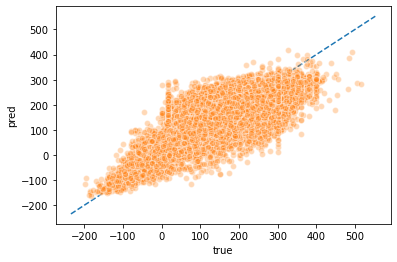

In [24]:
dmin=min(true.min(),pred.min())
dmax=max(true.max(),pred.max())

bg.plt.plot([dmin-273,dmax-273],[dmin-273,dmax-273],"--")
bg.plt.plot(true-273,pred-273,"o",alpha=0.3,markeredgecolor="w")
bg.plt.xlabel("true")
bg.plt.ylabel("pred")
bg.plt.show()
bg.plt.close()
#plt.plot(np.exp(pred),np.exp(true),"o")
#plt.show()
#plt.close()

In [22]:
#print(np.abs(np.exp(pred)-np.exp(true)).mean())
print(np.abs(pred-true).mean())
print((np.abs(pred-true)**2).mean())

29.686869802211564
1518.3001991288572


In [ ]:
32.911037992548636
1829.047509953999


In [ ]:
!nvidia-smi